In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'rlops',
    'password': 'jTeL85L!',
    'options': f'-c search_path=rl',
}

In [2]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [3]:
# Load the game buffer
with psycopg2.connect(**dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))

In [4]:
# Load the policy training history
log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
log['time'] = pd.to_datetime(log.time)

Text(0, 0.5, 'Reward')

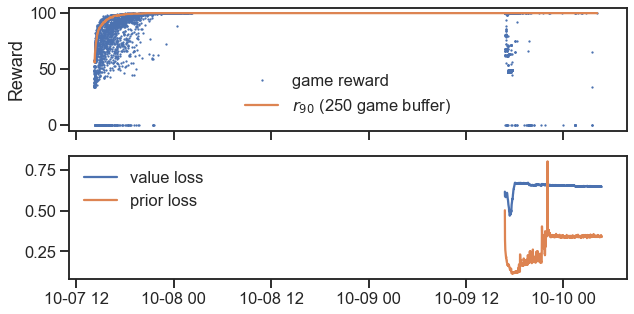

In [5]:
fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

axs[1].plot(log.time, log.policy_wrapper_loss, label='value loss')
axs[1].plot(log.time, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

axs[0].set_ylabel('Reward')

In [6]:
df.tail(20)

,id,time,experiment_id,gameid,real_reward,final_smiles
6169,19086,2020-10-10 01:23:43.924746,0009,99854247,0.000000,[O]OON=C=O
6170,19087,2020-10-10 01:23:51.452331,0009,0d31fc7f,0.000000,C1=C=C(N2N=N2)N=1
6171,19088,2020-10-10 01:23:55.402385,0009,7d04b195,0.000000,[O]OON=C=O
6172,19089,2020-10-10 01:23:57.038451,0009,328adec8,0.000000,O=C=O
6173,19090,2020-10-10 01:23:57.130434,0009,7081af82,0.000000,[O]OON=C=O
6174,19091,2020-10-10 01:24:01.114746,0009,d592ff86,0.000000,NC1=C(O[O])N1
6175,19092,2020-10-10 01:24:03.197746,0009,c7490b6f,100.048030,C=C1C=[C]C(C)=C1C(C)C
6176,19093,2020-10-10 01:24:03.680200,0009,1e1d4e86,0.000000,O=C=O
6177,19094,2020-10-10 01:29:57.814599,0009,079015e7,100.048030,C=C1C=[C]C(C)=C1C(C)C
6178,19095,2020-10-10 01:50:50.241622,0009,309ad869,100.048030,C=C1C=[C]C(C)=C1C(C)C


INFO:rdkit:Enabling RDKit 2020.03.4 jupyter extensions


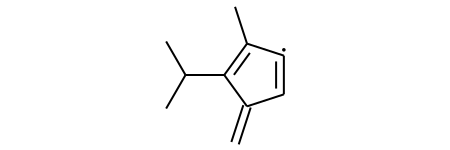

In [11]:
import rdkit
rdkit.Chem.MolFromSmiles('C=C1C=[C]C(C)=C1C(C)C')

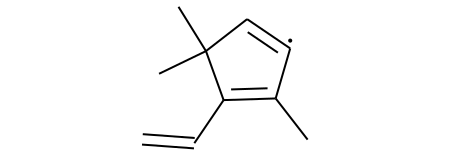

In [13]:
rdkit.Chem.MolFromSmiles('C=CC1=C(C)[C]=CC1(C)C')

In [12]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(934699, 7)

In [15]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    orig_costs = np.array(costs)
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return orig_costs[is_efficient_mask]
    else:
        return is_efficient

In [16]:
rew_df.head()

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
0,[C]#CC#N,2020-10-01 18:49:39.179745,48.074257,C,22.521230,0.488940,1
1,C[C]=C=N,2020-10-01 18:49:40.270978,55.539494,C,31.348166,0.516173,2
2,C=C=[C]O,2020-10-01 18:49:40.757469,56.670605,C,28.143957,0.429467,1
3,NC[C]=O,2020-10-01 18:49:40.759254,47.112630,C,29.438765,0.646523,0
4,[C]#COO,2020-10-01 18:49:40.970014,48.538612,C,22.561136,0.480450,1


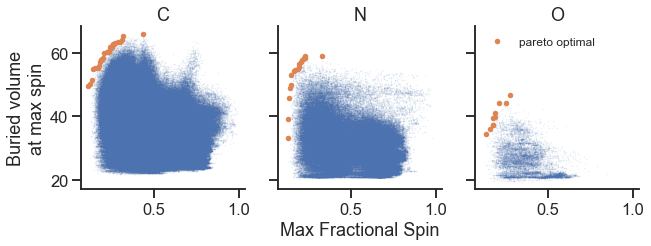

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O']):
    
    vals = rew_df[rew_df.atom_type == atom][['max_spin', 'buried_vol']].dropna()
    vals['buried_vol'] *= -1
    pareto_index = is_pareto_efficient(vals.values, return_mask=False)
    pareto_points = vals.iloc[pareto_index]
    optimal += [vals.iloc[pareto_index].index]
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1)
    
    ax.plot(pareto_points['max_spin'], -pareto_points['buried_vol'], '.', label='pareto optimal')
    
    ax.set_title(atom)

    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12)
sns.despine()    

TODO: 
* Maybe do ranked reward on an atom-by-atom basis?
* Also look into sulfur-containing radicals
* Some additional chemical feasibility constraints

In [19]:
# rew_df.iloc[optimal[0]]